# Introduction
Hi, this is Zihan Wan here with Jay Devnani.  
Assignment team num: Assignment 4_17

## Stock Prices Prediction

You are already looking at financial time series as homework. See how far into the future you can predict stock prices for your three chosen stocks.
Make sure your model can do a prediction score above 70%.

For the assignment submission, please submit the file in zip format which contains your dataset and a single jupyter notebook containing all codes.
 
Good luck!



## Disney
### 1.Grab and save the data

In [1]:
# From pandas_datareader import data, wb
import pandas as pd
# The line below is the fix for is_list_like lub
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import datetime

# One year of historical data 
start = datetime.datetime(2020, 10, 13)
end = datetime.datetime(2021, 10, 13)

disney = web.DataReader('DIS', 'yahoo', start, end)

# Save data to csv
data = pd.DataFrame(disney).to_csv('../../data/disney_raw_data.csv')

### 2.Load the data

In [2]:
data = pd.read_csv('../../data/disney_raw_data.csv')
data.head(5)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2020-10-13,131.360001,127.900002,129.800003,128.960007,22389000,128.960007
1,2020-10-14,129.500000,125.290001,129.139999,126.589996,11531500,126.589996
2,2020-10-15,127.400002,124.430000,125.000000,127.360001,7744000,127.360001
3,2020-10-16,128.119995,126.330002,127.809998,126.809998,6291700,126.809998
4,2020-10-19,127.400002,123.709999,127.370003,124.230003,6576900,124.230003


### 3.Reorganize the data

In [3]:
data.insert(0,'Ticker','Disney')
data.drop(['Adj Close'],axis = 1, inplace = True)
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume
0,Disney,2020-10-13,131.360001,127.900002,129.800003,128.960007,22389000
1,Disney,2020-10-14,129.500000,125.290001,129.139999,126.589996,11531500
2,Disney,2020-10-15,127.400002,124.430000,125.000000,127.360001,7744000
3,Disney,2020-10-16,128.119995,126.330002,127.809998,126.809998,6291700
4,Disney,2020-10-19,127.400002,123.709999,127.370003,124.230003,6576900


### 4.Plot closing price and do exponential smoothing
The trend shown might mean that the stock is likely to go down in the following days.

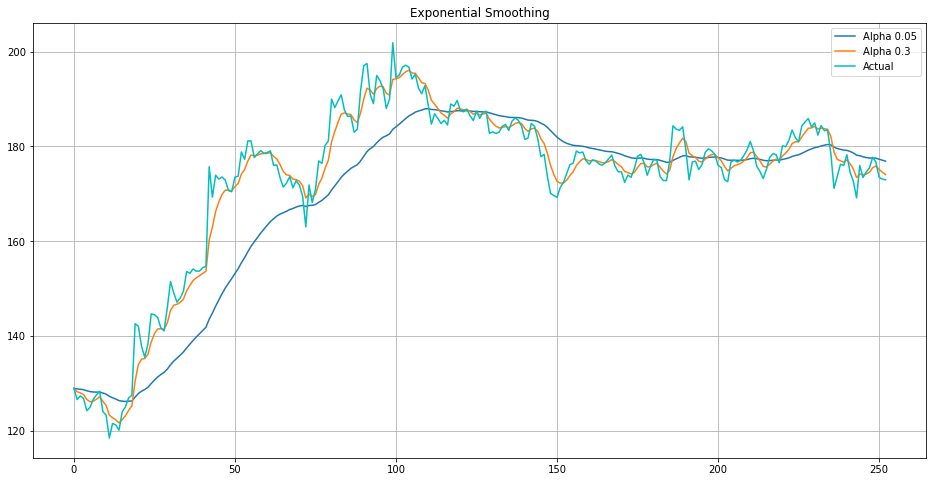

In [4]:
import matplotlib.pyplot as plt

def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(16, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(data.Close, [0.05, 0.3])

### 5.Apply the Dickey-Fuller test
By the Dickey-Fuller test, the time series is non-stationary and it seems that there is no clear seasonality.

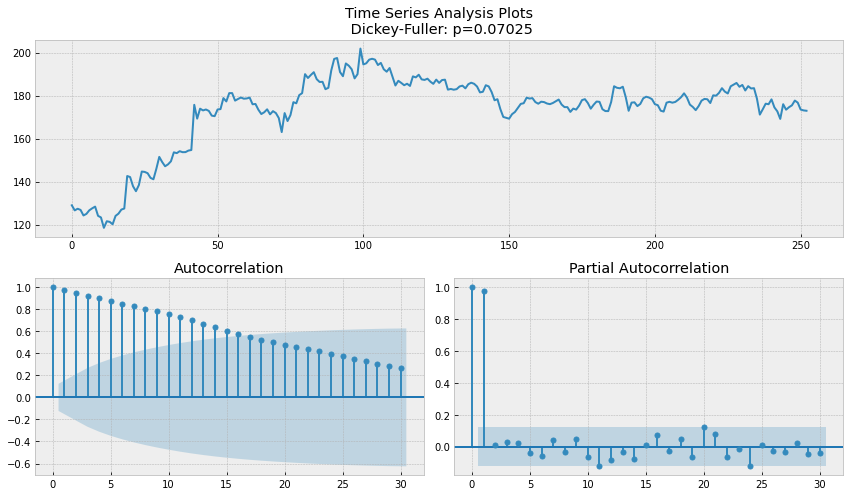

In [5]:
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        #smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        #smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Close, lags=30)

### 6.Make the process stationary
To get rid of the high autocorrelation and to make the process stationary, We can calculate the n-th (n=1 is the default) discrete difference along a given axis to find out about gains/losses, using numpy's `diff` API

,Ticker,Date,High,Low,Open,Close,Volume,Difference
0,Disney,2020-10-13,131.360001,127.900002,129.800003,128.960007,22389000,NaN
1,Disney,2020-10-14,129.500000,125.290001,129.139999,126.589996,11531500,-2.370010
2,Disney,2020-10-15,127.400002,124.430000,125.000000,127.360001,7744000,0.770004
3,Disney,2020-10-16,128.119995,126.330002,127.809998,126.809998,6291700,-0.550003
4,Disney,2020-10-19,127.400002,123.709999,127.370003,124.230003,6576900,-2.579994


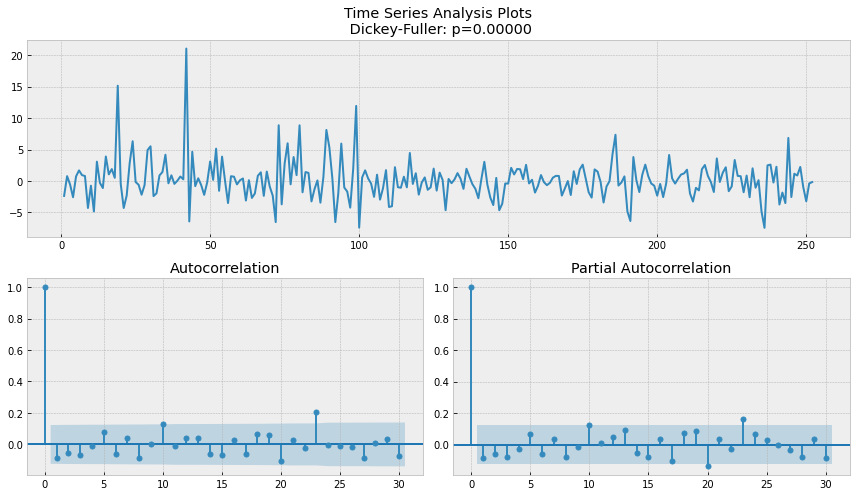

In [6]:
# Take the first difference to remove to make the process stationary 
difference = data['Close'].diff()
# and store the values in the main data frame
data['Difference'] = difference

tsplot(difference[1:], lags=30)
data.head(5)

### 7.Calculate six indicators 
Reference：[Predicting the Direction of Stock Prices - Using Random Forest in Python.pdf](https://github.com/areed1192/sigma_coding_youtube/blob/master/python/python-data-science/machine-learning/random-forest/Resources%20-%20Documentation/Predicting%20the%20Direction%20of%20Stock%20Prices%20-%20Using%20Random%20Forest%20in%20Python.pdf)  

The indicators we need to calculate：  
- Relative Strength Index (RSI)
- Stochastic Oscillator (K_percent)
- Williams %R (R_percent)
- Moving Average Convergence Divergnece (MACD)
- Price Rate Of Change (PROC)
- On Balance Volume (OBV)

#### 7.1 Relative Strength Index (RSI)
RSI ranges from 0 to 100, and generally, when RSI is above 70, it may indicate that the stock is overbought and when RSI is below 30, it may indicate the stock is oversold.

In [7]:
# Identify the up days and down days
# Make a copy of the data frame twice
up, down = data[['Ticker','Difference']].copy(), data[['Ticker','Difference']].copy()

# For up(down) days, if the difference is less(greater) than 0 set to 0
up.loc['Difference'] = up.loc[(up['Difference'] < 0), 'Difference'] = 0
down.loc['Difference'] = down.loc[(down['Difference'] > 0), 'Difference'] = 0
# We need difference to be absolute
down['Difference'] = down['Difference'].abs()

# Calculate the 14 day RSI
# Calculate the EWMA (Exponential Weighted Moving Average)
# meaning older values are given less weight compared to newer values
ewma_up = up.groupby('Ticker')['Difference'].transform(lambda x: x.ewm(span = 14).mean())
ewma_down = down.groupby('Ticker')['Difference'].transform(lambda x: x.ewm(span = 14).mean())

# Calculate the Relative Strength(RS) and Relative Strength Index(RSI)
rs = ewma_up / ewma_down
rsi = 100.0 - (100.0 / (1.0 + rs))

# Store the values in the main data frame
data['RSI'] = rsi
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume,Difference,RSI
0,Disney,2020-10-13,131.360001,127.900002,129.800003,128.960007,22389000,NaN,NaN
1,Disney,2020-10-14,129.500000,125.290001,129.139999,126.589996,11531500,-2.370010,0.000000
2,Disney,2020-10-15,127.400002,124.430000,125.000000,127.360001,7744000,0.770004,27.266312
3,Disney,2020-10-16,128.119995,126.330002,127.809998,126.809998,6291700,-0.550003,22.263260
4,Disney,2020-10-19,127.400002,123.709999,127.370003,124.230003,6576900,-2.579994,11.169947


#### 7.2 Stochastic Oscillator (K_percent)
Stochastic Oscillator follows the speed or the momentum of the price. It measures the level of the closing price relative to the low-high range over a period of time(We choose 14 days).

In [8]:
# Make a copy of the high and low column
low, high = data[['Ticker','Low']].copy(), data[['Ticker','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max
low = low.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = 14).min())
high = high.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = 14).max())

# Calculate the Stochastic Oscillator(K_percent)
k_percent = 100 * ((data['Close'] - low) / (high - low))

# Store the values in the main data frame
data['K_percent'] = k_percent
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume,Difference,RSI,K_percent
0,Disney,2020-10-13,131.360001,127.900002,129.800003,128.960007,22389000,NaN,NaN,NaN
1,Disney,2020-10-14,129.500000,125.290001,129.139999,126.589996,11531500,-2.370010,0.000000,NaN
2,Disney,2020-10-15,127.400002,124.430000,125.000000,127.360001,7744000,0.770004,27.266312,NaN
3,Disney,2020-10-16,128.119995,126.330002,127.809998,126.809998,6291700,-0.550003,22.263260,NaN
4,Disney,2020-10-19,127.400002,123.709999,127.370003,124.230003,6576900,-2.579994,11.169947,NaN


#### 7.3 Williams %R (R_percent)
Williams %R ranges from -100 to 0. When its value is above -20, it indicates a sell signal and when its value is below -80, it indicates a buy signal(We choose 14 days).

In [9]:
# Calculate William %R(R_percent)
r_percent = ((high - data['Close']) / (high - low)) * - 100

# Store the values in the main data frame
data['R_percent'] = r_percent
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume,Difference,RSI,K_percent,R_percent
0,Disney,2020-10-13,131.360001,127.900002,129.800003,128.960007,22389000,NaN,NaN,NaN,NaN
1,Disney,2020-10-14,129.500000,125.290001,129.139999,126.589996,11531500,-2.370010,0.000000,NaN,NaN
2,Disney,2020-10-15,127.400002,124.430000,125.000000,127.360001,7744000,0.770004,27.266312,NaN,NaN
3,Disney,2020-10-16,128.119995,126.330002,127.809998,126.809998,6291700,-0.550003,22.263260,NaN,NaN
4,Disney,2020-10-19,127.400002,123.709999,127.370003,124.230003,6576900,-2.579994,11.169947,NaN,NaN


#### 7.4 Moving Average Convergence Divergnece (MACD)
EMA stands for Exponential Moving Average. When the MACD goes below the SingalLine, it indicates a sell signal. When it goes above the SignalLine, it indicates a buy signal.

In [10]:
# Calculate the MACD(specify the span of 26 and 12)
ema_26 = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA(specify the span 9) ——> SignalLine
signalLine = macd.ewm(span = 9).mean()

# Store the values in the main data frame
data['MACD'] = macd
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume,Difference,RSI,K_percent,R_percent,MACD
0,Disney,2020-10-13,131.360001,127.900002,129.800003,128.960007,22389000,NaN,NaN,NaN,NaN,0.000000
1,Disney,2020-10-14,129.500000,125.290001,129.139999,126.589996,11531500,-2.370010,0.000000,NaN,NaN,-0.053173
2,Disney,2020-10-15,127.400002,124.430000,125.000000,127.360001,7744000,0.770004,27.266312,NaN,NaN,-0.043876
3,Disney,2020-10-16,128.119995,126.330002,127.809998,126.809998,6291700,-0.550003,22.263260,NaN,NaN,-0.058429
4,Disney,2020-10-19,127.400002,123.709999,127.370003,124.230003,6576900,-2.579994,11.169947,NaN,NaN,-0.167771


#### 7.5 Price Rate Of Change (PROC)
It measures the most recent change in price with respect to the price in n days ago.(9 days of prediction window seemed to be the standard window, so let n = 9.)

In [11]:
# Calculate the PROC
proc = data.groupby('Ticker')['Close'].transform(lambda x: x.pct_change(periods = 9))

# Store the values in the main data frame
data['PROC'] = proc
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume,Difference,RSI,K_percent,R_percent,MACD,PROC
0,Disney,2020-10-13,131.360001,127.900002,129.800003,128.960007,22389000,NaN,NaN,NaN,NaN,0.000000,NaN
1,Disney,2020-10-14,129.500000,125.290001,129.139999,126.589996,11531500,-2.370010,0.000000,NaN,NaN,-0.053173,NaN
2,Disney,2020-10-15,127.400002,124.430000,125.000000,127.360001,7744000,0.770004,27.266312,NaN,NaN,-0.043876,NaN
3,Disney,2020-10-16,128.119995,126.330002,127.809998,126.809998,6291700,-0.550003,22.263260,NaN,NaN,-0.058429,NaN
4,Disney,2020-10-19,127.400002,123.709999,127.370003,124.230003,6576900,-2.579994,11.169947,NaN,NaN,-0.167771,NaN


#### 7.6 On Balance Volume (OBV)
On balance volume (OBV) (Granville 1976) utilizes changes in volume to estimate changes in stock prices. This technical indicator is used to buying and selling trends of a stock by considering the cumulative volume.

In [12]:
def obv(data):
    
    # Grab the Volume and Close column
    volume = data['Volume']
    diff = data['Close'].diff()

    # Intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # Calculate the On Balance Volume(OBV)
    for i, j in zip(diff, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series
    return pd.Series(obv_values)
        
# Calculate the OBV(applying obv function)
obv = obv(data)

# Store the values in the main data frame
data['OBV'] = obv
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume,Difference,RSI,K_percent,R_percent,MACD,PROC,OBV
0,Disney,2020-10-13,131.360001,127.900002,129.800003,128.960007,22389000,NaN,NaN,NaN,NaN,0.000000,NaN,0
1,Disney,2020-10-14,129.500000,125.290001,129.139999,126.589996,11531500,-2.370010,0.000000,NaN,NaN,-0.053173,NaN,-11531500
2,Disney,2020-10-15,127.400002,124.430000,125.000000,127.360001,7744000,0.770004,27.266312,NaN,NaN,-0.043876,NaN,-3787500
3,Disney,2020-10-16,128.119995,126.330002,127.809998,126.809998,6291700,-0.550003,22.263260,NaN,NaN,-0.058429,NaN,-10079200
4,Disney,2020-10-19,127.400002,123.709999,127.370003,124.230003,6576900,-2.579994,11.169947,NaN,NaN,-0.167771,NaN,-16656100


### 8.Create the Close_next Column

We can shift Close shifted by n rows up, so that we may use information from previous n day to predict the next n day's Close value.

In [13]:
# Shift Close up to predict the next n day
n = 5
close_next = data.Close.shift(-n)
data['Close_next'] = close_next
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume,Difference,RSI,K_percent,R_percent,MACD,PROC,OBV,Close_next
0,Disney,2020-10-13,131.360001,127.900002,129.800003,128.960007,22389000,NaN,NaN,NaN,NaN,0.000000,NaN,0,124.949997
1,Disney,2020-10-14,129.500000,125.290001,129.139999,126.589996,11531500,-2.370010,0.000000,NaN,NaN,-0.053173,NaN,-11531500,126.629997
2,Disney,2020-10-15,127.400002,124.430000,125.000000,127.360001,7744000,0.770004,27.266312,NaN,NaN,-0.043876,NaN,-3787500,127.559998
3,Disney,2020-10-16,128.119995,126.330002,127.809998,126.809998,6291700,-0.550003,22.263260,NaN,NaN,-0.058429,NaN,-10079200,128.350006
4,Disney,2020-10-19,127.400002,123.709999,127.370003,124.230003,6576900,-2.579994,11.169947,NaN,NaN,-0.167771,NaN,-16656100,124.059998


### 9.Drop NaN Values

In [14]:
# Drop any row that has a 'NaN' value 
data = data.dropna()
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume,Difference,RSI,K_percent,R_percent,MACD,PROC,OBV,Close_next
13,Disney,2020-10-30,121.750000,119.089996,120.639999,121.250000,8090200,-0.290001,35.433836,28.450088,-71.549912,-0.793989,-0.023988,-18839700,127.459999
14,Disney,2020-11-02,122.930000,119.809998,122.239998,120.129997,9186000,-1.120003,32.125595,23.634839,-76.365161,-0.908558,-0.038575,-28025700,142.589996
15,Disney,2020-11-03,125.070000,121.370003,121.610001,124.019997,8144900,3.889999,50.606621,60.248406,-39.751594,-0.748145,-0.020611,-19880800,142.110001
16,Disney,2020-11-04,126.860001,123.410004,123.580002,125.070000,7483000,1.050003,54.467863,69.565206,-30.434794,-0.551545,-0.019520,-12397800,137.820007
17,Disney,2020-11-05,128.619995,125.800003,126.779999,126.959999,7654800,1.889999,60.827830,85.425836,-14.574164,-0.275046,-0.010830,-4743000,135.520004


### 10.Split the Data

Create training **independent variables** (X_train) and **test independent variables** (X_test), and **training dependent variable** (y_train) and **test dependent variable** (y_test).  
Use an uppercase X to denote that X is multi-dimensional, while use a lowercase y to denote that y is one-dimensional.

In [15]:
# Grab X and y columns
X = data[['RSI','K_percent','R_percent','MACD','PROC','OBV']]
y = data['Close_next']

In [16]:
# For a better view, let's look at the transpose:
X.T

,13,14,15,16,17,18,19,20,21,22,...,238,239,240,241,242,243,244,245,246,247
RSI,3.543384e+01,3.212560e+01,5.060662e+01,5.446786e+01,6.082783e+01,6.242974e+01,8.452517e+01,8.274385e+01,6.797154e+01,6.121127e+01,...,4.081855e+01,4.021963e+01,4.815440e+01,3.841759e+01,3.446194e+01,2.809476e+01,4.919925e+01,4.368398e+01,4.678799e+01,4.923065e+01
K_percent,2.845009e+01,2.363484e+01,6.024841e+01,6.956521e+01,8.542584e+01,8.981566e+01,8.328408e+01,8.170774e+01,6.761908e+01,6.006571e+01,...,3.892183e+01,3.757412e+01,4.975738e+01,2.959571e+01,2.019918e+01,8.298721e-01,4.137521e+01,2.625969e+01,3.307649e+01,3.823354e+01
R_percent,-7.154991e+01,-7.636516e+01,-3.975159e+01,-3.043479e+01,-1.457416e+01,-1.018434e+01,-1.671592e+01,-1.829226e+01,-3.238092e+01,-3.993429e+01,...,-6.107817e+01,-6.242588e+01,-5.024262e+01,-7.040429e+01,-7.980082e+01,-9.917013e+01,-5.862479e+01,-7.374031e+01,-6.692351e+01,-6.176646e+01
MACD,-7.939894e-01,-9.085580e-01,-7.481453e-01,-5.515448e-01,-2.750455e-01,-2.713335e-02,1.150511e+00,2.014845e+00,2.372258e+00,2.465067e+00,...,-5.899869e-01,-7.905213e-01,-7.583419e-01,-1.022835e+00,-1.365184e+00,-1.897848e+00,-1.747909e+00,-1.813934e+00,-1.753254e+00,-1.616331e+00
PROC,-2.398779e-02,-3.857543e-02,-2.061123e-02,-1.952021e-02,-1.082982e-02,2.740611e-02,1.563539e-01,1.995442e-01,1.339477e-01,1.176908e-01,...,-4.274384e-02,-4.854577e-02,-2.269737e-02,-5.363049e-02,-5.814336e-02,-7.794191e-02,-1.455689e-02,1.337856e-02,5.528401e-03,-4.368819e-03
OBV,-1.883970e+07,-2.802570e+07,-1.988080e+07,-1.239780e+07,-4.743000e+06,1.516700e+06,3.715140e+07,1.903600e+07,9.435100e+06,-4.333100e+06,...,9.740510e+07,9.169230e+07,9.944730e+07,9.031420e+07,8.407340e+07,7.011100e+07,8.227600e+07,7.507540e+07,8.187360e+07,8.787880e+07


Now, let's split the data into a training set, and a test set using the `train_test_split` API:

In [17]:
from sklearn.model_selection import train_test_split
# Split X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

### 11.Create ML model and predict!
Using `RandomForestRegressor` from the `sk-learn` package.  
Score our model at how good it is in predicting next n day's Close value from previous n day's variables.   
**In this case, n = 5, meaning we can predict price after 5 days.**

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the data to the model
rf_model.fit(X_train, y_train)

#Get the prediction values
prediction = rf_model.predict(X_test)
data2 = pd.DataFrame({'Valid':y_test, 'Prediction': prediction})
data2.head(5)

,Valid,Prediction
235,178.259995,174.641299
114,189.729996,183.131102
227,184.410004,178.456799
204,179.289993,176.010700
150,176.470001,177.444799


In [19]:
# Get R2 measure (indicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)

0.9296982994394353

**So the above is a code display with Disney's stock as an example, and the same for the other two stocks.   
I will omit some steps and focus on showing the final results of the other two.**

## Pixar

In [20]:
# From pandas_datareader import data, wb
import pandas as pd
# The line below is the fix for is_list_like lub
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import datetime

# One year of historical data 
start = datetime.datetime(2020, 10, 13)
end = datetime.datetime(2021, 10, 13)

pixar = web.DataReader('3227.TWO', 'yahoo', start, end)

# Save data to csv
data = pd.DataFrame(pixar).to_csv('../../data/pixar_raw_data.csv')

In [21]:
data = pd.read_csv('../../data/pixar_raw_data.csv')

In [22]:
data.insert(0,'Ticker','Pixar')
data.drop(['Adj Close'],axis = 1, inplace = True)

In [23]:
# Take the first difference to remove to make the process stationary 
difference = data['Close'].diff()
# and store the values in the main data frame
data['Difference'] = difference

In [24]:
# Identify the up days and down days
# Make a copy of the data frame twice
up, down = data[['Ticker','Difference']].copy(), data[['Ticker','Difference']].copy()

# For up(down) days, if the difference is less(greater) than 0 set to 0
up.loc['Difference'] = up.loc[(up['Difference'] < 0), 'Difference'] = 0
down.loc['Difference'] = down.loc[(down['Difference'] > 0), 'Difference'] = 0
# We need difference to be absolute
down['Difference'] = down['Difference'].abs()

# Calculate the 14 day RSI
# Calculate the EWMA (Exponential Weighted Moving Average)
# meaning older values are given less weight compared to newer values
ewma_up = up.groupby('Ticker')['Difference'].transform(lambda x: x.ewm(span = 14).mean())
ewma_down = down.groupby('Ticker')['Difference'].transform(lambda x: x.ewm(span = 14).mean())

# Calculate the Relative Strength(RS) and Relative Strength Index(RSI)
rs = ewma_up / ewma_down
rsi = 100.0 - (100.0 / (1.0 + rs))

# Store the values in the main data frame
data['RSI'] = rsi

In [25]:
# Make a copy of the high and low column
low, high = data[['Ticker','Low']].copy(), data[['Ticker','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max
low = low.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = 14).min())
high = high.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = 14).max())

# Calculate the Stochastic Oscillator(K_percent)
k_percent = 100 * ((data['Close'] - low) / (high - low))

# Store the values in the main data frame
data['K_percent'] = k_percent

In [26]:
# Calculate William %R(R_percent)
r_percent = ((high - data['Close']) / (high - low)) * - 100

# Store the values in the main data frame
data['R_percent'] = r_percent

In [27]:
# Calculate the MACD(specify the span of 26 and 12)
ema_26 = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA(specify the span 9) ——> SignalLine
signalLine = macd.ewm(span = 9).mean()

# Store the values in the main data frame
data['MACD'] = macd

In [28]:
# Calculate the PROC
proc = data.groupby('Ticker')['Close'].transform(lambda x: x.pct_change(periods = 9))

# Store the values in the main data frame
data['PROC'] = proc

In [29]:
def obv(data):
    
    # Grab the Volume and Close column
    volume = data['Volume']
    diff = data['Close'].diff()

    # Intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # Calculate the On Balance Volume(OBV)
    for i, j in zip(diff, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series
    return pd.Series(obv_values)
        
# Calculate the OBV(applying obv function)
obv = obv(data)

# Store the values in the main data frame
data['OBV'] = obv

In [30]:
# Shift Close up to predict the next n day
n = 5
close_next = data.Close.shift(-n)
data['Close_next'] = close_next

In [31]:
# Drop any row that has a 'NaN' value 
data = data.dropna()
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume,Difference,RSI,K_percent,R_percent,MACD,PROC,OBV,Close_next
13,Pixar,2020-10-30,174.5,170.0,174.5,170.0,3492000.0,-4.5,29.644523,12.121212,-87.878788,-0.904617,-0.034091,-9316000.0,190.0
14,Pixar,2020-11-02,171.5,166.0,170.5,168.5,4306000.0,-1.5,26.689425,13.513514,-86.486486,-1.136080,-0.037143,-13622000.0,207.0
15,Pixar,2020-11-03,174.5,170.0,170.0,173.5,2546000.0,5.0,47.007025,46.875000,-53.125000,-0.994185,-0.022535,-11076000.0,196.5
16,Pixar,2020-11-04,182.0,174.5,177.0,182.0,8191000.0,8.5,65.669875,100.000000,-0.000000,-0.347614,0.040000,-2885000.0,199.5
17,Pixar,2020-11-05,182.0,178.5,182.0,179.5,5538000.0,-2.5,58.659129,84.375000,-15.625000,-0.005803,0.014124,-8423000.0,198.5


In [32]:
# Grab X and y columns
X = data[['RSI','K_percent','R_percent','MACD','PROC','OBV']]
y = data['Close_next']

In [33]:
from sklearn.model_selection import train_test_split
# Split X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [34]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the data to the model
rf_model.fit(X_train, y_train)

#Get the prediction values
prediction = rf_model.predict(X_test)
data2 = pd.DataFrame({'Valid':y_test, 'Prediction': prediction})
data2.head(5)

,Valid,Prediction
152,191.0,194.240
213,163.5,163.445
135,173.0,193.660
198,163.5,190.830
154,195.5,194.010


In [35]:
# Get R2 measure (indicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)

0.8047891402640042

## Netflix

In [36]:
# From pandas_datareader import data, wb
import pandas as pd
# The line below is the fix for is_list_like lub
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import datetime

# One year of historical data 
start = datetime.datetime(2020, 10, 13)
end = datetime.datetime(2021, 10, 13)

netflix = web.DataReader('NFLX', 'yahoo', start, end)

# Save data to csv
data = pd.DataFrame(netflix).to_csv('../../data/netflix_raw_data.csv')

In [37]:
data = pd.read_csv('../../data/netflix_raw_data.csv')

In [38]:
data.insert(0,'Ticker','Netflix')
data.drop(['Adj Close'],axis = 1, inplace = True)

In [39]:
# Take the first difference to remove to make the process stationary 
difference = data['Close'].diff()
# and store the values in the main data frame
data['Difference'] = difference

In [40]:
# Identify the up days and down days
# Make a copy of the data frame twice
up, down = data[['Ticker','Difference']].copy(), data[['Ticker','Difference']].copy()

# For up(down) days, if the difference is less(greater) than 0 set to 0
up.loc['Difference'] = up.loc[(up['Difference'] < 0), 'Difference'] = 0
down.loc['Difference'] = down.loc[(down['Difference'] > 0), 'Difference'] = 0
# We need difference to be absolute
down['Difference'] = down['Difference'].abs()

# Calculate the 14 day RSI
# Calculate the EWMA (Exponential Weighted Moving Average)
# meaning older values are given less weight compared to newer values
ewma_up = up.groupby('Ticker')['Difference'].transform(lambda x: x.ewm(span = 14).mean())
ewma_down = down.groupby('Ticker')['Difference'].transform(lambda x: x.ewm(span = 14).mean())

# Calculate the Relative Strength(RS) and Relative Strength Index(RSI)
rs = ewma_up / ewma_down
rsi = 100.0 - (100.0 / (1.0 + rs))

# Store the values in the main data frame
data['RSI'] = rsi

In [41]:
# Make a copy of the high and low column
low, high = data[['Ticker','Low']].copy(), data[['Ticker','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max
low = low.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = 14).min())
high = high.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = 14).max())

# Calculate the Stochastic Oscillator(K_percent)
k_percent = 100 * ((data['Close'] - low) / (high - low))

# Store the values in the main data frame
data['K_percent'] = k_percent

In [42]:
# Calculate William %R(R_percent)
r_percent = ((high - data['Close']) / (high - low)) * - 100

# Store the values in the main data frame
data['R_percent'] = r_percent

In [43]:
# Calculate the MACD(specify the span of 26 and 12)
ema_26 = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA(specify the span 9) ——> SignalLine
signalLine = macd.ewm(span = 9).mean()

# Store the values in the main data frame
data['MACD'] = macd

In [44]:
# Calculate the PROC
proc = data.groupby('Ticker')['Close'].transform(lambda x: x.pct_change(periods = 9))

# Store the values in the main data frame
data['PROC'] = proc

In [45]:
def obv(data):
    
    # Grab the Volume and Close column
    volume = data['Volume']
    diff = data['Close'].diff()

    # Intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # Calculate the On Balance Volume(OBV)
    for i, j in zip(diff, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series
    return pd.Series(obv_values)
        
# Calculate the OBV(applying obv function)
obv = obv(data)

# Store the values in the main data frame
data['OBV'] = obv

In [46]:
# Shift Close up to predict the next n day
n = 5
close_next = data.Close.shift(-n)
data['Close_next'] = close_next

In [47]:
# Drop any row that has a 'NaN' value 
data = data.dropna()
data.head(5)

,Ticker,Date,High,Low,Open,Close,Volume,Difference,RSI,K_percent,R_percent,MACD,PROC,OBV,Close_next
13,Netflix,2020-10-30,505.880005,472.209991,502.010010,475.739990,7807900,-28.470001,25.257215,3.520142,-96.479858,-6.057886,-0.103595,-53062500,514.729980
14,Netflix,2020-11-02,486.299988,475.000000,478.869995,484.119995,4408200,8.380005,34.357523,11.876749,-88.123251,-6.148290,-0.078604,-48654300,470.500000
15,Netflix,2020-11-03,495.309998,478.760010,484.929993,487.220001,3690200,3.100006,37.600431,18.278136,-81.721864,-5.951596,-0.003742,-44964100,480.239990
16,Netflix,2020-11-04,507.730011,493.980011,495.359985,496.950012,5137300,9.730011,47.070370,30.126660,-69.873340,-5.125593,0.024153,-39826800,490.760010
17,Netflix,2020-11-05,518.729980,503.450012,506.559998,513.760010,5372800,16.809998,59.363970,59.706884,-40.293116,-3.370218,0.052183,-34454000,486.769989


In [48]:
# Grab X and y columns
X = data[['RSI','K_percent','R_percent','MACD','PROC','OBV']]
y = data['Close_next']

In [49]:
from sklearn.model_selection import train_test_split
# Split X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [50]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the data to the model
rf_model.fit(X_train, y_train)

#Get the prediction values
prediction = rf_model.predict(X_test)
data2 = pd.DataFrame({'Valid':y_test, 'Prediction': prediction})
data2.head(5)

,Valid,Prediction
235,592.640015,594.225387
114,544.530029,536.716196
227,582.869995,600.017383
204,510.720001,543.817397
150,502.359985,496.592497


In [51]:
# Get R2 measure (indicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)

0.8292242781820616